<a href="https://colab.research.google.com/github/DrAlexSanz/Pix2Pix-DOTCSV/blob/master/Pix2Pix_DOTCSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is just for me, an implementation of the pix2pix algorithm following DotCSV's tutorial. It is very useful to get to know Tensorflow 2.0 and then I will use it for different things.

Video: [Video dotCSV](https://youtu.be/YsrMGcgfETY)

The tutorial, as he explains at the beginning, is based on this code:

[Tutorial Pix 2 Pix tensorflow 2.0](https://www.tensorflow.org/tutorials/generative/pix2pix)

In [0]:
%tensorflow_version 2.x

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os, shutil
import glob
from PIL import Image, ImageOps, ImageFilter

# Define paths

# Root

PATH = "/content/drive/My Drive/Pix2PixFlowers"

# Input path

INPATH = "/content/drive/My Drive/Pix2PixFlowers/InputFlowers"

# Sketch path

SKEPATH = "/content/drive/My Drive/Pix2PixFlowers/SketchFlowers"

# Output path

OUTPATH = PATH = "/content/drive/My Drive/Pix2PixFlowers/OutputFlowers"

# Checkpoints directory

CKPATH = PATH = "/content/drive/My Drive/Pix2PixFlowers/Checkpoints"

Activate drive to load the data

In [0]:
# !wget https://raw.githubusercontent.com/DrAlexSanz/Pix2Pix-DOTCSV/master/pix2pix.py
# from pix2pix import *

In [0]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os, shutil
from distutils.dir_util import copy_tree


import numpy as np
import tensorflow as tf
import os, shutil
from keras import backend as K
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Add, BatchNormalization, Concatenate, Conv2DTranspose, ZeroPadding2D, Cropping2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, Adadelta, Adagrad
from tensorflow.keras.callbacks import History, ModelCheckpoint
import matplotlib.pyplot as plt
import glob
import cv2
from PIL import Image, ImageFilter
from scipy.ndimage.filters import gaussian_filter
K.set_image_data_format("channels_last")



# Define paths

# Root

PATH = "/content/drive/My Drive/Pix2PixFlowers"

# Input path

INPATH = "/content/drive/My Drive/Pix2PixFlowers/InputFlowers"

# Sketch path

SKEPATH = "/content/drive/My Drive/Pix2PixFlowers/SketchFlowers"

# Output path

OUTPATH = PATH = "/content/drive/My Drive/Pix2PixFlowers/OutputFlowers"

# Checkpoints directory

CKPATH = PATH = "/content/drive/My Drive/Pix2PixFlowers/Checkpoints"



def make_sketches(path_in, path_sketch):
    
    """
    This takes one of the real images and creates the "blurred" or modified images
    path in is where the input images are, path sketch is the place where the modified ones will be stored.
    """
    
    os.chdir(path_in)
    file_list = glob.glob("*")
    file_list.sort()
#   os.chdir(path_sketch)

    for file in file_list:
        a = Image.open(file)
        a = a.filter(ImageFilter.GaussianBlur(radius = 2))
        a = a.filter(ImageFilter.GaussianBlur(radius = 4))
        a = a.filter(ImageFilter.GaussianBlur(radius = 10))
        a = ImageOps.posterize(a, 4)
        b = np.asarray(a).copy() # Returns a view, not the array!! Need a copy to assign and play with it.
        b[b[:, :, 1] < 100] = 0
        im = Image.fromarray(np.uint8(b))
        os.chdir(path_sketch)
        im.save(file)
        os.chdir(path_in)
#         print(b.shape)
        
        
    
    return None
    

def resize(in_img, out_img, width, height):
    """
    Take an image and the target image, with height and width, and resize it.
    """
    
    inimg = tf.image.resize(in_img, [height, width])
    outimg = tf.image.resize(in_img, [height, width])
    
    return inimg, outimg
    
    

def normalize(in_img, out_img):
    """
    DotCSV does -1 to 1, I usually do 0 to 1. It doesn't have big implications and it is just a numerical stability issue
    In this case I put a lot of pixels to 0 with the green saturation, I risk that all my images become "flat"
    """
    
    inimg = (in_img / 127.5) - 1
    outimg = (out_img / 127.5) - 1
    
    return inimg, outimg
    
    
def random_jitter(in_img, out_img):
    """
    The paper advises to implement it. Also it's a data augmentation pipeline, can't hurt although this will increase running time
    
    """
    
    # first, resize
    inimage, outimage = resize(in_img, out_img, 286, 286) # Values from the paper
    
    # Stack, like this the crop will be the same (think physical stacking)
    stacked_img = tf.stack([inimage, outimage], axis = 0)
    cropped_img = tf.image.random_crop(stacked_img, size = [2, IMG_HEIGHT, IMG_WIDTH, 3])
    
    # Un-stack
    inimage = cropped_img[0]
    outimage = cropped_img[1]
    
    # Flip only if half of the times, randomly
    if tf.random.uniform(()) > 0.5:
        inimage = tf.image.flip_left_right(inimage)
        outimage = tf.image.flip_left_right(outimage)
        
    return inimage, outimage
    
    
def load_image(filename, augment = True):
    """
    Read one image and augment (or not)
    """
    # Read jpg, make it float just in case, and the [] at the end, take whatever dimensions, but only 3 channels. If it's png it has 4 and jpeg will decode it anyway.
    inimage = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + "/" + filename)), tf.float32)[..., :3]
    skeimage = tf.cast(tf.image.decode_jpeg(tf.io.read_file(SKEPATH + "/" + filename)), tf.float32)[..., :3]
    
    inimage, skeimage = resize(inimage, skeimage, IMG_HEIGHT, IMG_WIDTH)
    
    if augment == True:
        inimage, outimage = random_jitter(inimage, skeimage)
    
    inimage, outimage = normalize(inimage, outimage)
    
    return inimage, outimage
    

def load_train_image(filename):
    return load_image(filename, augment = True)
    
def load_test_image(filename):
    return load_image(filename, augment = False)

In [27]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


(-0.5, 590.5, 499.5, -0.5)

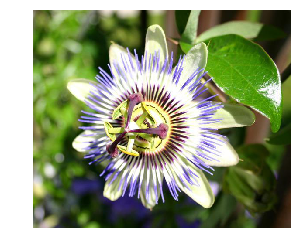

In [28]:
a = INPATH + "/image_00001.jpg"
a = mpimg.imread(a)
plt.imshow(a)
plt.axis("off")

In [0]:
# make_sketches(INPATH, SKEPATH) #Call if ever needed

(-0.5, 666.5, 499.5, -0.5)

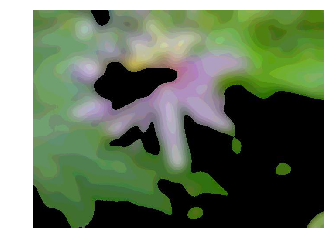

In [30]:
a = SKEPATH + "/image_00019.jpg"
a = mpimg.imread(a)
plt.imshow(a)
plt.axis("off")

Now that everything is loaded correctly, let's make a train/test split list of names.

In [0]:
imgurls = !ls -1 "{INPATH}"

n = 1500
train_n = round(n * 0.8)

# Make a random list, the flowers were somehow sorted

randurls = np.copy(imgurls)

np.random.seed(13)

np.random.shuffle(randurls) # Don't save it!

# Split

trurls = randurls[:train_n]
testurls = randurls[train_n:n]




Now I only have a list. Then I will have to actually load the images.

In [0]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

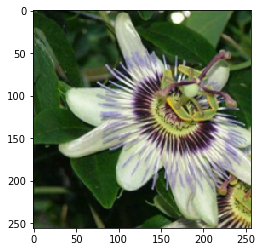

In [33]:
plt.imshow(((load_train_image(randurls[0])[0]) + 1) / 2)